Matis Braun

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

!tar xzf /kaggle/input/navires-2024-fait-main/ships24.tgz

!ls /kaggle/working

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
#from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

from tensorflow.keras.layers import RandomRotation, RandomWidth, RandomHeight, RandomZoom, RandomFlip, Resizing, RandomContrast, RandomBrightness
from tensorflow.keras import Sequential
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#GET PICTURES AND LOAD THEM
image_size = (128, 192)
batch_size = 64

/kaggle/input/navires-2024-fait-main/ships24.tgz
ships_gray  test.npy


2024-11-24 22:49:54.728750: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-24 22:49:54.728898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-24 22:49:55.013109: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Récupération des datasets

Nos images sont de dimension 128 x 192.
Nous allons utiliser keras.utils.image_dataset_from_directory pour récupérer les images de navires dans un répertoire donnée et détecte automatiquement le nombre de classe (ici 10).

In [3]:
image_size = (128, 192)
batch_size = 32


train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/kaggle/working/ships_gray/",
    label_mode="categorical",
    color_mode='grayscale',
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

print(train_ds)

Found 42204 files belonging to 10 classes.
Using 33764 files for training.
Using 8440 files for validation.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 192, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


On constate qu'il n'y a pas le même nombre d'images par classe de bateaux, ce qui peux donner des biais au réseau durant l'apprentissage. Nous verrons comment régler cela plus tard.

In [4]:
def count_images_in_directory(directory_path):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')
    files = os.listdir(directory_path)
    images = [file for file in files if file.lower().endswith(valid_extensions)]
    return len(images)

directory_path = '/kaggle/working/ships_gray/'
num_images = count_images_in_directory(directory_path + 'destroyer_scaled')
print(f"Number of images in directory: {num_images}")
num_images2 = count_images_in_directory(directory_path + 'cv_scaled')
print(f"Number of images in directory: {num_images2}")

Number of images in directory: 6646
Number of images in directory: 2029


Ici, nous allons augmenter la taille de nos données, ce qui permettra d'avoir plus de diversité d'images pour avoir un meilleur entraînement.
Pour cela, nous allons prendre les images déjà existantes de notre dataset et en ajouter d'autres en faisant des transformations (changement de contraste, zoom,...) sur ces images préexistantes.

In [5]:
data_augmentation = Sequential([
    #RandomRotation(0.1, input_shape=(image_size[0], image_size[1], 1)),
    RandomWidth(0.2),
    RandomHeight(0.2),
    RandomZoom(0.2),
    RandomFlip('horizontal'),
    RandomContrast(0.2),
    RandomBrightness(0.2),
    Resizing(image_size[0], image_size[1])
])

AUTOTUNE = tf.data.AUTOTUNE

def augment(image, label):
    image = data_augmentation(image)
    return image, label

train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 192, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

Regardons maintenant comment sont nos images.

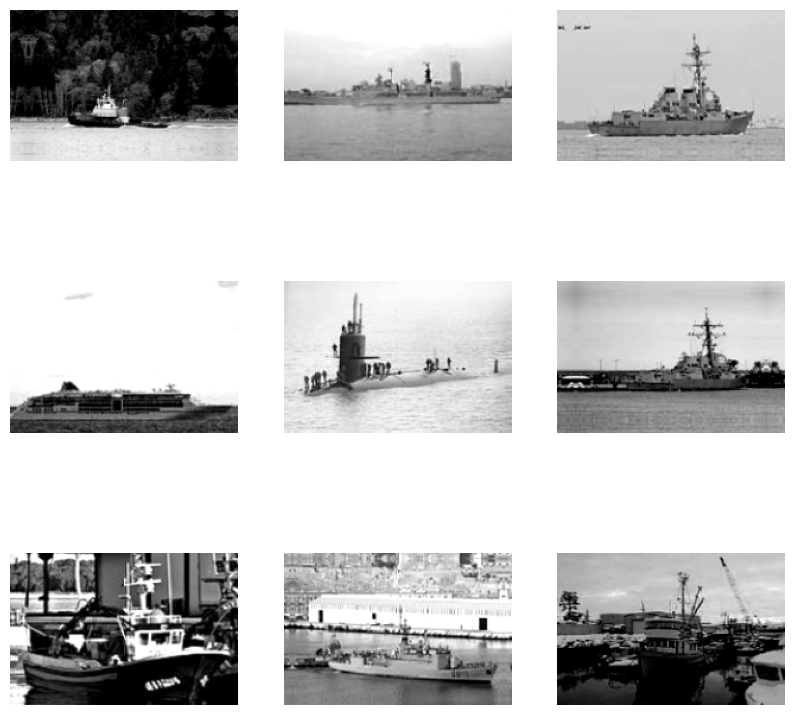

In [6]:
def display_images(dataset, labels, num_images=9):
    images, labels = next(iter(dataset))
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8").squeeze(), cmap='gray')
        plt.axis("off")
    plt.show()

display_images(train_ds, 10)

# Création de notre réseau de neuronnes

Voici notre réseau de neurones. C'est un réseaux de neurones convolutifs, qui est extrêmement utilisé pour les reconnaissances d'images et classification d'images. Ici, nous avons 5 blocs de convolution, dont la taille augmente petit à petit. Cela permet de trouver sur l'image à chaque fois de plus en plus de caractéristiques qu'il n'aurait pas vu avant. Ensuite, notre réseau termine par des couches Dropout qui permettent d'empêcher l'overfitting. Pour la compilation, on utilise la loss 'categorical_corssentropy' souvent utilisé pour les classifications avec plusieurs classes, et on utilise l'optimizer Adam. Notre réseaux à 26 couches. 

In [7]:
def create_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),

        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),

        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.GlobalAveragePooling2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax'),
    ])
    return model


input_shape = (128, 192, 1)
model = create_model(input_shape)

model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()
print("Nombre de couches : ", len(model.layers))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 192, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 192, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 192, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 96, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 12, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 12, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 12, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 12, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,32

 Total params: 4,881,130 (18.62 MB)

 Trainable params: 4,879,146 (18.61 MB)

 Non-trainable params: 1,984 (7.75 KB)

Nombre de couches :  26


Pour cette partie, nous avons fait ce qui s'appelle une class_weight. Dans les données que l'on nous a donné, le nombre d'images dans chaque classes n'est pas la même, ce qui donne un biais au réseau de neuronnes. class_weight va nous permettre de donner plus d'importance aux classes aillant un moins grand nombre d'images que celle qui en ont le plus, pour que le réseau n'ait pas de biais comme par exemple coastguard_scaled est l'image avec le moins d'image donc il a moins de chance que ce soit lui qu'un autre.

In [8]:
labels = np.concatenate([y for x, y in train_ds], axis=0)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(labels, axis=1)),
    y=np.argmax(labels, axis=1)
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.220238525478858, 1: 0.6041152263374485, 2: 1.4288616165890817, 3: 0.6115558775584133, 4: 2.07268262737876, 5: 0.6357371493127472, 6: 1.1909700176366842, 7: 1.2640958442530887, 8: 1.4705574912891985, 9: 1.2136592379583033}


Ici, nous avons fait ce qui s'appelle des callbacks. Le Early stopping permet d'arrêter l'entrainement de notre réseau de neuronnes si jamais il ne s'améliore pas après 5 epochs. Le Reduce LR On Plateau permet de réduire le learning_rate si notre réseau stagne.

In [10]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

Ici, on entraine notre réseau de neuronnes

In [12]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/5
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 93s 88ms/step - accuracy: 0.9584 - loss: 0.1381 - val_accuracy: 0.9089 - val_loss: 0.3489 - learning_rate: 2.5000e-04
Epoch 2/5
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 92s 87ms/step - accuracy: 0.9610 - loss: 0.1254 - val_accuracy: 0.9124 - val_loss: 0.3409 - learning_rate: 2.5000e-04
Epoch 3/5
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 92s 87ms/step - accuracy: 0.9646 - loss: 0.1184 - val_accuracy: 0.9139 - val_loss: 0.3608 - learning_rate: 2.5000e-04
Epoch 4/5
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 92s 87ms/step - accuracy: 0.9655 - loss: 0.1132 - val_accuracy: 0.9143 - val_loss: 0.3658 - learning_rate: 2.5000e-04
Epoch 5/5
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 92s 87ms/step - accuracy: 0.9679 - loss: 0.1059 - val_accuracy: 0.9180 - val_loss: 0.3311 - learning_rate: 2.5000e-04


# Résultats de l'entrainement

Ici, on va regarder la différence entre la loss et la val_loss. Comme on peut le voir, les loss descendent très rapidement au debut pour ensuite stagner de plus en plus vers la fin

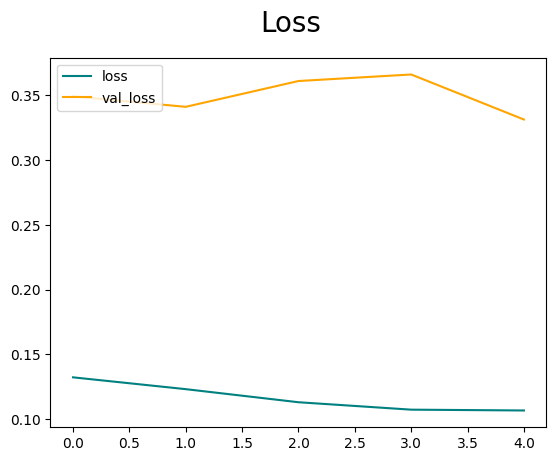

In [13]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Ici, on va regarder la différence entre l'accuracy et la val_accuracy. Comment on peut le voir, c'est l'inverse, les accuracy montent très rapidement mais finissent aussi par stagner, meme si on peut voir une légère différence entre l'accuracy et la val_accuracy qui est moins haute

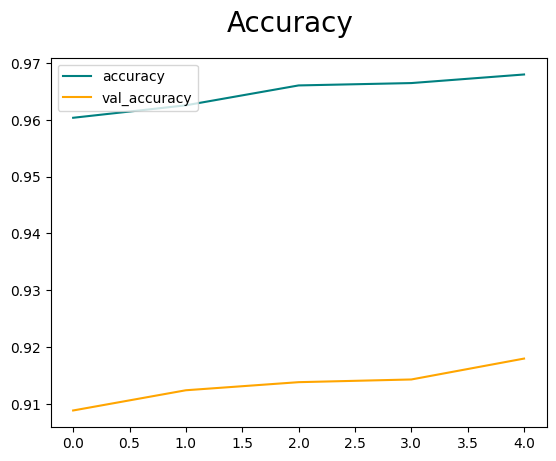

In [14]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Et voici la matrice de confusion des prédictions de notre réseau de neuronnes. Dans l'ensemble, on voit que la diagonale à la plus grande intensité, ce qui montre que le modèle sait plutôt bien gérer les vrais positifs.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


W0000 00:00:1732492807.418201      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

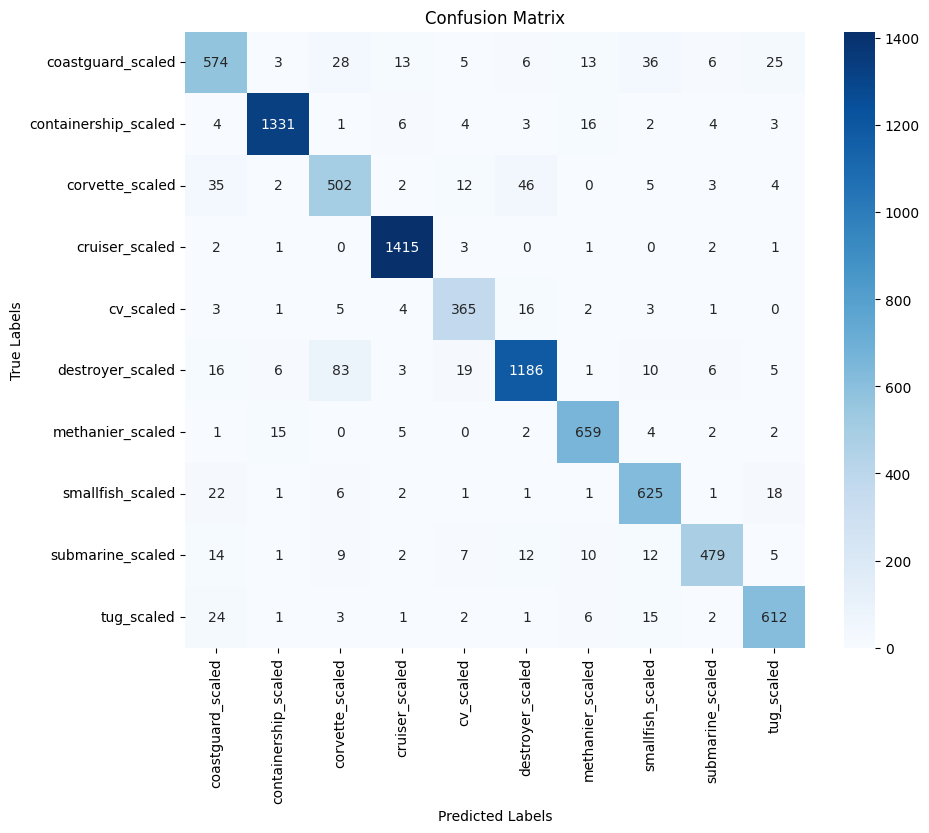

In [15]:
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

conf_matrix = confusion_matrix(y_true, y_pred)

class_names = ['coastguard_scaled', 'containership_scaled', 'corvette_scaled', 'cruiser_scaled', 'cv_scaled', 'destroyer_scaled', 'methanier_scaled', 'smallfish_scaled', 'submarine_scaled', 'tug_scaled']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Dans l'ensemble on observe que la diagonale a la plus grande intensité, ce qui montre que le modèle sait plutôt bien gérer les vrais positifs.

In [ ]:
#Test with the test suite of Kaggle
X_test = np.load('/kaggle/working/test.npy', allow_pickle=True)

res = model.predict(X_test).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("reco_nav.csv", index_label="ID")

!head reco_nav.csv

import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'reco_nav.csv')